<a href="https://colab.research.google.com/github/lukasztracz195/DeepLearningInPythonCourse/blob/main/kvasir_dataset_VGG16_transfer_learning_resice_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wykorzystanie już wytrenowanego modelu VGG16 do klasyfikacji datasetu kvasir

#1. Przygotowanie środowiska

##1.1 Sprawdzenie wersji pythona zainstalowanej na serwerze Google Colaboratory

In [ ]:
!python --version

Python 3.7.12


##1.2 Instalcja odpowiedniej wersji pakietu Tensorflow


In [ ]:
#To determine which version you're using:
!pip show tensorflow

# For a specific version:
# !pip install tensorflow==2.4.1

Name: tensorflow
Version: 2.6.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: astunparse, absl-py, h5py, keras-preprocessing, termcolor, protobuf, keras, tensorboard, gast, flatbuffers, clang, google-pasta, grpcio, wrapt, numpy, six, typing-extensions, wheel, tensorflow-estimator, opt-einsum
Required-by: kapre


##1.3 Instalcja odpowiedniej wersji pakietu keras

In [ ]:
!pip3 show keras
# !pip3 install keras==2.4.3


Name: keras
Version: 2.6.0
Summary: TensorFlow Keras.
Home-page: https://keras.io/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: tensorflow, keras-vis


##1.4 Podłączenie się do dysku Google (Obcjonalne by móc zapisywać utworzone pliki)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# 2. Przygotowanie danych

##2.1 Zdefiniowanie linków do datasetów kvasir

In [ ]:
kvasir_dataset_v2_google_drive_url = "https://drive.google.com/u/0/uc?export=download&confirm=s837&id=1rQ79Usso9vrI9FiWCvP7Km8ZcpibslUB"


##2.2 Pobranie i rozpakowanie danych kvasir_dataset_v2

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

kvasir_dataset_v2_file_id = '1rQ79Usso9vrI9FiWCvP7Km8ZcpibslUB'
gdd.download_file_from_google_drive(file_id='1rQ79Usso9vrI9FiWCvP7Km8ZcpibslUB',
                                    dest_path='./kvasir-dataset-v2.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
!rm -fR ./kvasir-dataset-v2.zip

###2.3.2 Sprawdzenie jakimi rozmiarami i formatami obrazów dysponujemy

### 2.3.2 Dane jakimi dysponujemy wyamgają ujednolicenia ich do tego samego rozmiaru by móc ich użyć w modelu sieci neuronowej

##2.4 Zmiana rozmiarów obrazów w datasecie

###2.4.1 Utowrzenie funkcji do zmainy rozmiaru obrazu

###2.4.2 Zmiana rozmiaru obrazów na żadany w datasecie

###2.4.3 Sprawdzenie czy zmiana rozmiaru danych się powiodła

###2.5 Podział danych na treningowe i testowe

In [ ]:
import os
import numpy as np
import shutil
import random
global_path = "/content"
path_to_dataset = "kvasir-dataset-v2"
root_dir = global_path + "/" + path_to_dataset + "/"
classes= ["dyed-lifted-polyps", "dyed-resection-margins", "esophagitis", "normal-cecum", "normal-pylorus", "normal-z-line", "polyps", "ulcerative-colitis"]
# classes_dir = ["dyed", "not_dyed"]
# dictionary_mapping_src_to_output_class = dict()
# dictionary_mapping_src_to_output_class["dyed"] = ["dyed-lifted-polyps", "dyed-resection-margins"]
# dictionary_mapping_src_to_output_class["not_dyed"] = ["esophagitis", "normal-cecum", "normal-pylorus", "normal-z-line", "polyps", "ulcerative-colitis"]
# classes_dir = ["dyed", "not_dyed"]

test_ratio = 0.20

for cls in classes:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)

src = root_dir + cls

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print("*****************************")
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Testing: ', len(test_FileNames))
print("*****************************")


lab = classes

for name in train_FileNames:
    for i in lab:
        shutil.copy(name, root_dir +'train/' + i)

for name in test_FileNames:
    for i in lab:
        shutil.copy(name, root_dir +'test/' + i)
print("Copying Done!")

*****************************
Total images:  1000
Training:  800
Testing:  200
*****************************
Copying Done!


## 2.6 Przygotowanie datasetu zgodnie z api kerasa

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

global_path = "/content"
path_to_dataset = "kvasir-dataset-v2"
root_dir = global_path + "/" + path_to_dataset + "/"
TARGET_SIZE = (224,224)

train_ds = image_dataset_from_directory(
    directory=root_dir + "train/",
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    interpolation="bilinear",
    image_size=TARGET_SIZE)
test_ds = image_dataset_from_directory(
    directory=root_dir + "test/",
    labels='inferred',
    interpolation="bilinear",
    label_mode='categorical',
    batch_size=32,
    image_size=TARGET_SIZE)

Found 6400 files belonging to 8 classes.
Found 1600 files belonging to 8 classes.


#3. Opracowywanie modelu sieci neuronowej bazując na VGG16

##3.1 Przygotowanie modelu wytrenowanej już sieci VGG16

In [ ]:
import os
import numpy as np
import random

import keras
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

vgg = VGG16(weights='imagenet', include_top=True)
vgg.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

##3.2 Zmiana warstwy wyjściowej sieci VGG16 by zwracała 8 klas

In [ ]:
input_shape = (TARGET_SIZE[0],TARGET_SIZE[1],3)
nClasses = 8
print("INPUT_SHAPE: ", input_shape)
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(units=nClasses, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)
model_new.summary()

INPUT_SHAPE:  (224, 224, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (Non

##3.3 Wyłączenie trenowania dla warstw sieci VGG16 wszystkich prócz ostatniej

In [ ]:
from tensorflow.keras.optimizers import Adam

# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True


model_new.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#4 Trenowanie sieci neuronowej

##4.1 Zdefiniowanie callbacków dla naszej sieci

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
my_callbacks = [
    EarlyStopping(monitor='val_loss',min_delta=0.01, patience=5, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience=5, verbose=1 ,mode='auto')
]

##4.2 Dotrenowywanie naszej sieci VGG16 do naszego problemu

In [ ]:
batch_size = 4
epochs = 100_000
history = model_new.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_ds,
                    callbacks=my_callbacks)

Epoch 1/100000
200/200 [==============================] - 78s 332ms/step - loss: 2.5924 - accuracy: 0.0848 - val_loss: 2.5854 - val_accuracy: 0.1250
Epoch 2/100000
200/200 [==============================] - 67s 330ms/step - loss: 2.6125 - accuracy: 0.0827 - val_loss: 2.5338 - val_accuracy: 0.1250
Epoch 3/100000
200/200 [==============================] - 67s 329ms/step - loss: 2.5704 - accuracy: 0.0856 - val_loss: 2.4504 - val_accuracy: 0.1250
Epoch 4/100000
200/200 [==============================] - 67s 329ms/step - loss: 2.5917 - accuracy: 0.0870 - val_loss: 2.5420 - val_accuracy: 0.1250
Epoch 5/100000
200/200 [==============================] - 67s 329ms/step - loss: 2.5925 - accuracy: 0.0833 - val_loss: 2.3523 - val_accuracy: 0.1250
Epoch 6/100000
200/200 [==============================] - 67s 328ms/step - loss: 2.5743 - accuracy: 0.0872 - val_loss: 2.3894 - val_accuracy: 0.1250
Epoch 00006: early stopping


#5. Przegląd wyników uczenia się naszej sieci

##5.1 Zdefiniowanie funkcji do rysowania wykresów dla funckji straty i funckji dokładności

In [ ]:
def make_accuracy_plot(history):
  
    #   Funckja zwraca wykres dokładności (accuracy) modelu na zbiorze treningowym i walidacyjnym.
    

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(10,8))
    plt.plot(epochs, acc, label='Dokladność trenowania', marker='o')
    plt.plot(epochs, val_acc, label='Dokladność walidacji', marker='o')
    plt.legend()
    plt.title('Dokładność trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Dokładność')
    plt.show()

def make_loss_plot(history):

    #   Funkjca zwraca wykres straty (loss) modelu na zbiorze treningowym
    #   i walidacyjnym


    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss)+ 1)

    plt.figure(figsize = (10,8))
    plt.plot(epochs, loss, label='Strata trenowania', marker='o')
    plt.plot(epochs, val_loss, label="Strata walidacji", marker='o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Strata')
    plt.show()

## 5.2 Wykres dokładności trenowanie i walidacji

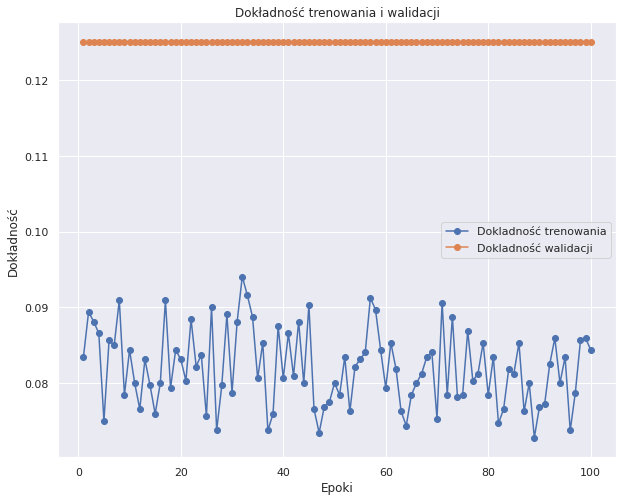

In [ ]:
make_accuracy_plot(history)

##5.3 Wykres straty trenowania i walidacji

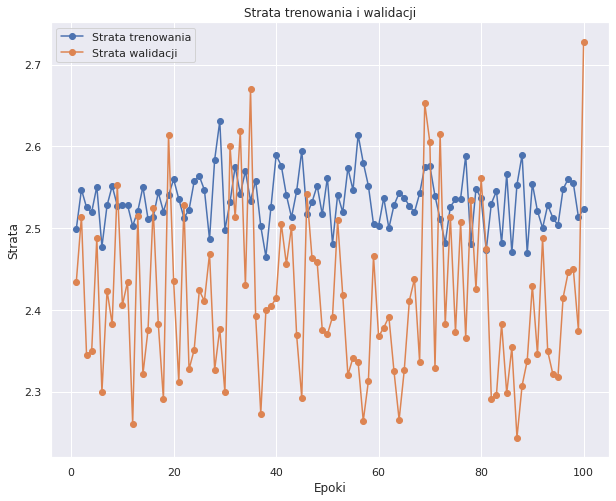

In [ ]:
make_loss_plot(history)